In [ ]:
!git clone https://github.com/VladislavEpifanow/CVLab3.git

Cloning into 'CVLab3'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (32/32), 76.22 MiB | 15.97 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
!ls

CVLab3	gdrive	sample_data


In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torchsummary import summary
from sklearn.metrics import f1_score

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

import time
from tqdm import tqdm

# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
device

'cuda'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [16]:
!ls

CVLab3	dandelion  gdrive  sample_data


In [4]:
# Data preprocessing
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
!cd ./gdrive/MyDrive/CVLab3/datasets/

In [5]:
# Load the dataset
data_dir = f"/content/gdrive/MyDrive/CVLab3/datasets"
image_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

In [6]:
image_dataset

Dataset ImageFolder
    Number of datapoints: 4260
    Root location: /content/gdrive/MyDrive/CVLab3/datasets
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
train_size = int(0.8 * len(image_dataset))
test_size = len(image_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, test_size])

In [48]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [49]:
#функция для вывода изображений
def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))
#имена классов
classes = ("buttercup", "coreopsis", "daffodil", "dandelion", "sunflower")

Real Labels:  daffodil dandelion coreopsis daffodil


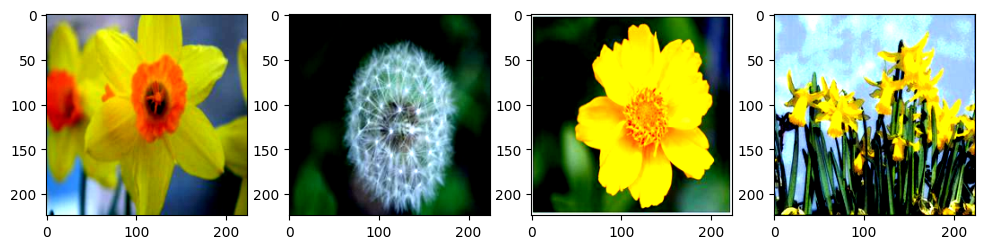

In [50]:
images, labels = next(iter(train_loader))
image_shower(images, labels)

In [35]:
labels[:4]

tensor([3, 1, 1, 1])

In [208]:
from torch.nn.modules import activation

class AlexNet(nn.Module):
    def __init__(self, num_classes=5):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(6400, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    def predict(self,x):
      out = self.forward(x)
      _, predicted = torch.max(out.data, 1)

In [209]:
num_classes = 5
num_epochs = 25
batch_size = 64
learning_rate = 0.001

model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)




In [210]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        # Переносим тензоры на device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

54it [00:16,  3.31it/s]


Epoch [1/25], Step [54/54], Loss: 0.9062


54it [00:16,  3.37it/s]


Epoch [2/25], Step [54/54], Loss: 0.9211


54it [00:16,  3.35it/s]


Epoch [3/25], Step [54/54], Loss: 0.8404


54it [00:16,  3.34it/s]


Epoch [4/25], Step [54/54], Loss: 0.6360


54it [00:16,  3.24it/s]


Epoch [5/25], Step [54/54], Loss: 0.4695


54it [00:16,  3.29it/s]


Epoch [6/25], Step [54/54], Loss: 0.6618


54it [00:16,  3.37it/s]


Epoch [7/25], Step [54/54], Loss: 0.3739


54it [00:16,  3.36it/s]


Epoch [8/25], Step [54/54], Loss: 0.4404


54it [00:16,  3.36it/s]


Epoch [9/25], Step [54/54], Loss: 1.1343


54it [00:16,  3.26it/s]


Epoch [10/25], Step [54/54], Loss: 0.4812


54it [00:16,  3.32it/s]


Epoch [11/25], Step [54/54], Loss: 0.9772


54it [00:16,  3.37it/s]


Epoch [12/25], Step [54/54], Loss: 0.0840


54it [00:16,  3.34it/s]


Epoch [13/25], Step [54/54], Loss: 0.1854


54it [00:16,  3.34it/s]


Epoch [14/25], Step [54/54], Loss: 0.2933


54it [00:16,  3.26it/s]


Epoch [15/25], Step [54/54], Loss: 0.1468


54it [00:16,  3.27it/s]


Epoch [16/25], Step [54/54], Loss: 0.3915


54it [00:16,  3.29it/s]


Epoch [17/25], Step [54/54], Loss: 0.1064


54it [00:16,  3.29it/s]


Epoch [18/25], Step [54/54], Loss: 0.0739


54it [00:16,  3.31it/s]


Epoch [19/25], Step [54/54], Loss: 0.0533


54it [00:16,  3.24it/s]


Epoch [20/25], Step [54/54], Loss: 0.0537


54it [00:16,  3.21it/s]


Epoch [21/25], Step [54/54], Loss: 0.0167


54it [00:16,  3.31it/s]


Epoch [22/25], Step [54/54], Loss: 0.0100


54it [00:16,  3.36it/s]


Epoch [23/25], Step [54/54], Loss: 0.0317


54it [00:16,  3.35it/s]


Epoch [24/25], Step [54/54], Loss: 0.0081


54it [00:16,  3.20it/s]

Epoch [25/25], Step [54/54], Loss: 0.0149


In [211]:
## Вычисляем accuracy на тестовой выборке
y_preds = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        y_preds.extend(predicted.tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(test_size, 100 * correct / total))

Accuracy of the network on the 852 test images: 91.31455399061034 %


In [212]:
y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])

In [213]:
from sklearn.metrics import classification_report


def evaluate_f1(y_true, y_pred):
    """
    Метод для расчёта avg f-1 score по датасету
    :param y_pred - предсказанные моделью метки классов
    :param y_true - реальные метки классов
    :return значение f-1 score по всем классам цветков
    """
    return classification_report(y_true, y_pred,
                                 target_names=['buttercup', 'coreopsis', 'daffodil', 'dandelion', 'sunflower'],
                                 output_dict=True)['macro avg']['f1-score']

In [214]:
evaluate_f1(y_test, y_preds)

0.9097356564772923

In [215]:
from sklearn.metrics import f1_score

In [216]:
f1_score(y_test, y_preds, average = "macro")

0.9097356564772923

In [217]:
torch.save(model, f"/content/gdrive/MyDrive/CVLab3/models/alexnet-f1score-0_90")

In [218]:
images, labels = next(iter(train_loader))

In [219]:
images[:1].shape

torch.Size([1, 3, 224, 224])

In [220]:
%%time
model.forward(images[:1].to(device))

CPU times: user 4.27 ms, sys: 0 ns, total: 4.27 ms
Wall time: 3.49 ms


tensor([[-2.0251,  2.6363, -1.1091,  0.1485, -0.1386]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [179]:
labels[0]

tensor(2)